In [177]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import missingno as msno
from scipy.stats import ks_2samp
import yaml
import shap
from lightgbm import LGBMClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, auc
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import plotly.express as px
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [179]:
df1, df2 = utils.load_datasets()
questions = utils.load_questions()
df1.head()

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  IPC  source  engnat  age  \
0   1   4   1   5   2   5   1   5   1    4  ...    1       1       1   18   
1   1   5   1   1   1   4   5   1   5    5  ...    1       0       1   19   
2   1   4   3   3   2   5   2   5   2    3  ...    1       0       2   18   
3   1   1   4   4   5   4   5   5   4    2  ...    1       1       1   19   
4   1   2   3   4   3   3   5   1   3    2  ...    2       1       1   16   

   education  gender  orientation  race  religion  hand  
0          2       2            2     6         1     1  
1          2       1            2     6         1     2  
2          2       2            1     1         1     1  
3          3       2            1     6         2     1  
4          2       1            1     6         2     1  

[5 rows x 57 columns]

In [180]:
df2.head()

E1  E2  E3  E4  E5  E6  E7  E8  E9  E10  ...  S56  S57  S58  S59  S60  EQ  \
0   3   1   3   2   4   3   1   3   1    3  ...    2    1    4    4    3  37   
1   4   3   3   2   2   2   2   3   4    4  ...    4    4    3    4    2  54   
2   3   3   3   1   1   2   2   2   3    1  ...    3    4    3    2    4  57   
3   2   2   2   1   2   1   3   2   4    4  ...    2    3    3    4    1  43   
4   3   1   2   4   4   2   3   3   2    3  ...    2    1    3    4    1  26   

   SQ  accuracy  gender  age  
0  49        80       1   39  
1  14        98       2   21  
2  12        95       2   32  
3  32        80       2   53  
4  57        97       1   17  

[5 rows x 125 columns]

<AxesSubplot:>

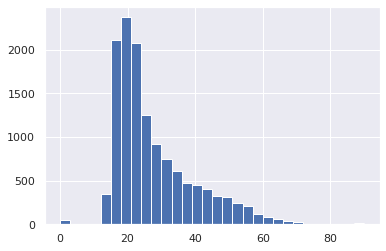

In [189]:
df2.age = df2.age.clip(0,90)
df2.age.hist(bins=30)

<AxesSubplot:>

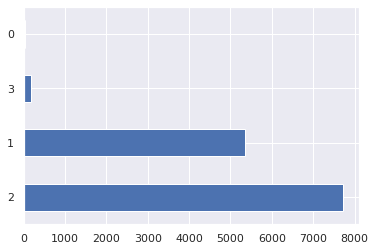

In [191]:
df2.gender.value_counts().plot.barh()

In [ ]:
df2_binary = df2.query('gender != 3')

In [3]:
questions

Q1                I have studied how to win at gambling.
Q10                   I am happiest when I am in my bed.
Q11                  I did not work very hard in school.
Q12                            I use lotion on my hands.
Q13    I would prefer a class in mathematics to a cla...
Q14                             I dance when I am alone.
Q15    I have thought it would be exciting to be an o...
Q16    When I was a child, I put on fake concerts and...
Q17              I have considered joining the military.
Q18                 I get dizzy when I stand up sharply.
Q19    I do not think it is normal to get emotionally...
Q2                   I have thought about dying my hair.
Q20       I sometimes feel like crying when I get angry.
Q21                         I do not remember birthdays.
Q22                            I save the letters I get.
Q23                       I playfully insult my friends.
Q24       I oppose medical experimentation with animals.
Q25         I could do an impre

# Preprocessing

**engnat** " Is English you native language?" 1=Yes, 2=No

**age** "What is your age?", entered as text (ages < 13 not recorded)

**education** "How much education have you completed?" 1=Less than high school, 2=High school, 3=University degree, 4=Graduate degree

**gender** 1=Male, 2=Female, 3=Other

**orientation** 1=Heterosexual, 2=Bisexual, 3=Homosexual, 4=Asexual, 5=Other

**race** 1=Mixed race, 2=Asian, 3=Black, 4=Native American, 5=Native Australian, 6=White, 7=Other

**religion** 1=Atheist/Agnostic, 2=Christian, 3=Muslim, 4=Jewish, 5=Hindu, 6=Buddhist, 7=Other

**hand** "What hand do you use to write with?" 1=Right, 2=Left, 3=Both

In [4]:
df.gender = df.gender.map({1: 'Male', 2: 'Female', 3: 'Other'})
df.orientation = df.orientation.map({1:'Heterosexual', 2:'Bisexual', 3:'Homosexual', 4:'Asexual', 5:'Other'})
df.race = df.race.map({1:'Mixed race', 2:'Asian', 3:'Black', 4:'Native American', 5:'Native Australian', 6:'White', 7:'Other'})
df.religion = df.religion.map({1:'Atheist', 2:'Christian', 3:'Muslim', 4:'Jewish', 5:'Hindu', 6:'Buddhist', 7:'Other'})
df.hand = df.hand.map({1:'Right', 2:'Left', 3:'Both'})
df.education = df.education.map({1:'< High School', 2:'High School', 3:'Bachelor Degree', 4:'Graduate degree'})
df.engnat = df.engnat.map({1:'Yes', 2:'No'})
df.source = df.source.map({1:'Google', 2:'Tumblr', 3:'Facebook', 4:'Reddit', 5:'Bing', 0:'Other'})

In [5]:
QUESTION_COLS = [col for col in df.columns if col.startswith('Q')]
NON_QUESTION_COLS = [col for col in df.columns if col not in QUESTION_COLS]

<AxesSubplot:>

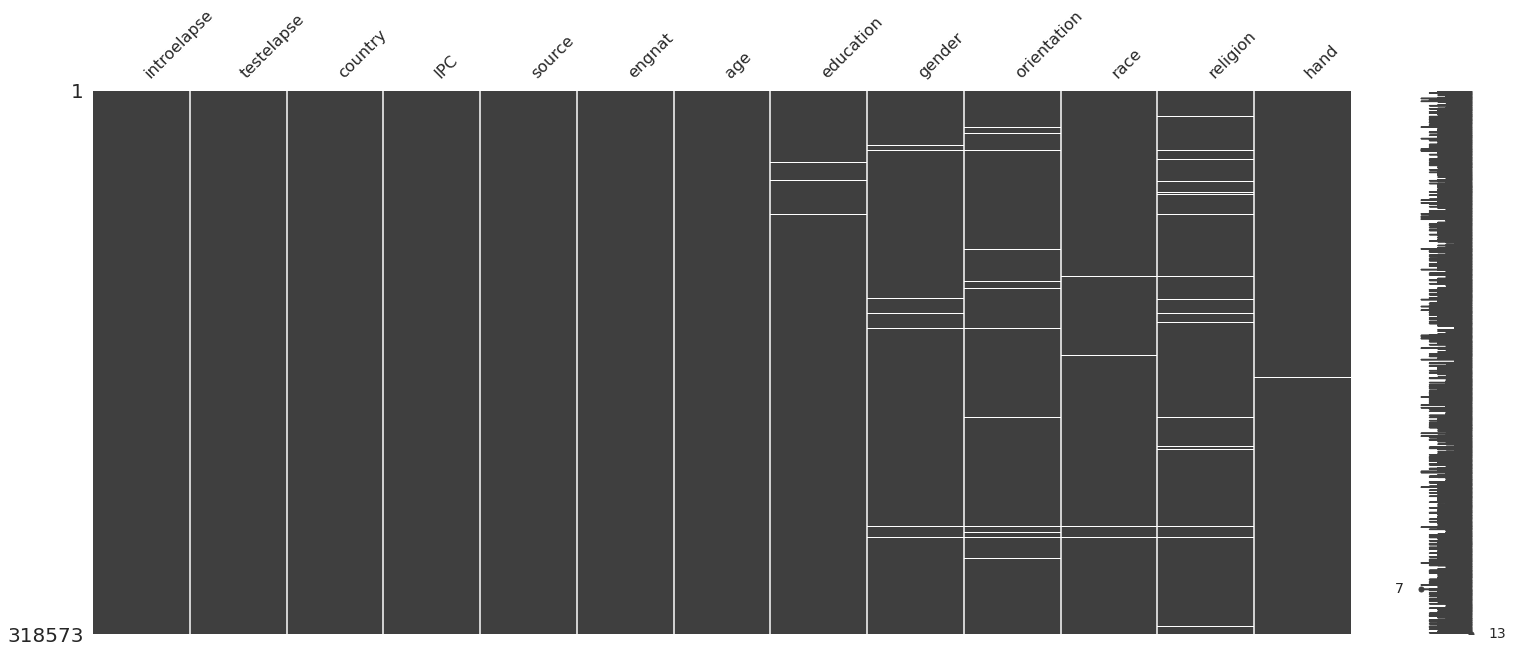

In [6]:
msno.matrix(df[NON_QUESTION_COLS])

In [7]:
df = df[df.gender.notnull()]

In [8]:
def get_age_group(age):
    if age <=16:
        return '<16'
    if age <=18:
        return '16-18'
    elif age <=22:
        return '18-22'
    elif age <=35:
        return '22-35'
    elif age <=45:
        return '35-45'
    else:
        return '45+'

    df.age = df.age.clip(upper=80)
df['age_bin'] = df.age.apply(lambda a: get_age_group(a))

In [9]:
grouped = df.query('gender != "Other"')\
    .groupby(['race', 'gender', 'age_bin', 'education', 'religion']).count().Q1.reset_index()\
    .rename(columns={'Q1': 'num_users'})\
    .sort_values(by='num_users', ascending=False)\
    .head(30)

In [10]:
fig = px.sunburst(grouped,
                  path=['age_bin', 'gender'], values='num_users')
fig.show()

<AxesSubplot:>

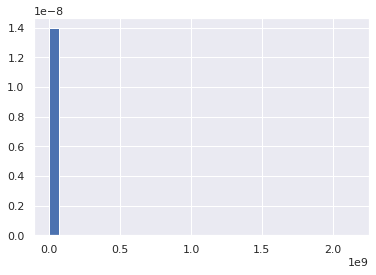

In [11]:
df.age.hist(cumulative=False, density=True, bins=30)

# EDA

In [12]:
sns.set(rc={'axes.facecolor':'#fafafa', 'figure.facecolor':'#fafafa'})

In [13]:
data_no_other_gender = df.query('gender != "Other"')
questions_dict = utils.load_questions(False)

def flatten(t):
    return [item for sublist in t for item in sublist]

def format_title(title):
    if len(title) > 45:
        words = title.split(' ')
        breakpoint = int(len(words)/2)
        part1 = words[:breakpoint]
        part2 = words[breakpoint:]
        new_title = (' ').join(part1) + '\n' + (' ').join(part2)
        return new_title
    return title
        
format_title(questions_dict['Q43'])

def plot_question(nquestion, ax, data, hue='gender'):
    sns.histplot(data=data, x=question, hue=hue, stat="percent", discrete=True,
                 common_norm=False, multiple="dodge", shrink=.8, ax=ax)
    
    title = f'{question}: {questions_dict[question]}'
    ax.set_title(f'{question}: {format_title(questions_dict[question])}', fontsize=12, fontfamily='monospace')
    ax.set_ylabel('')
    ax.set_xlabel('')
    #ax.set_xticklabels(['Disagree', 2, 3,4,'Agree'])
    return 

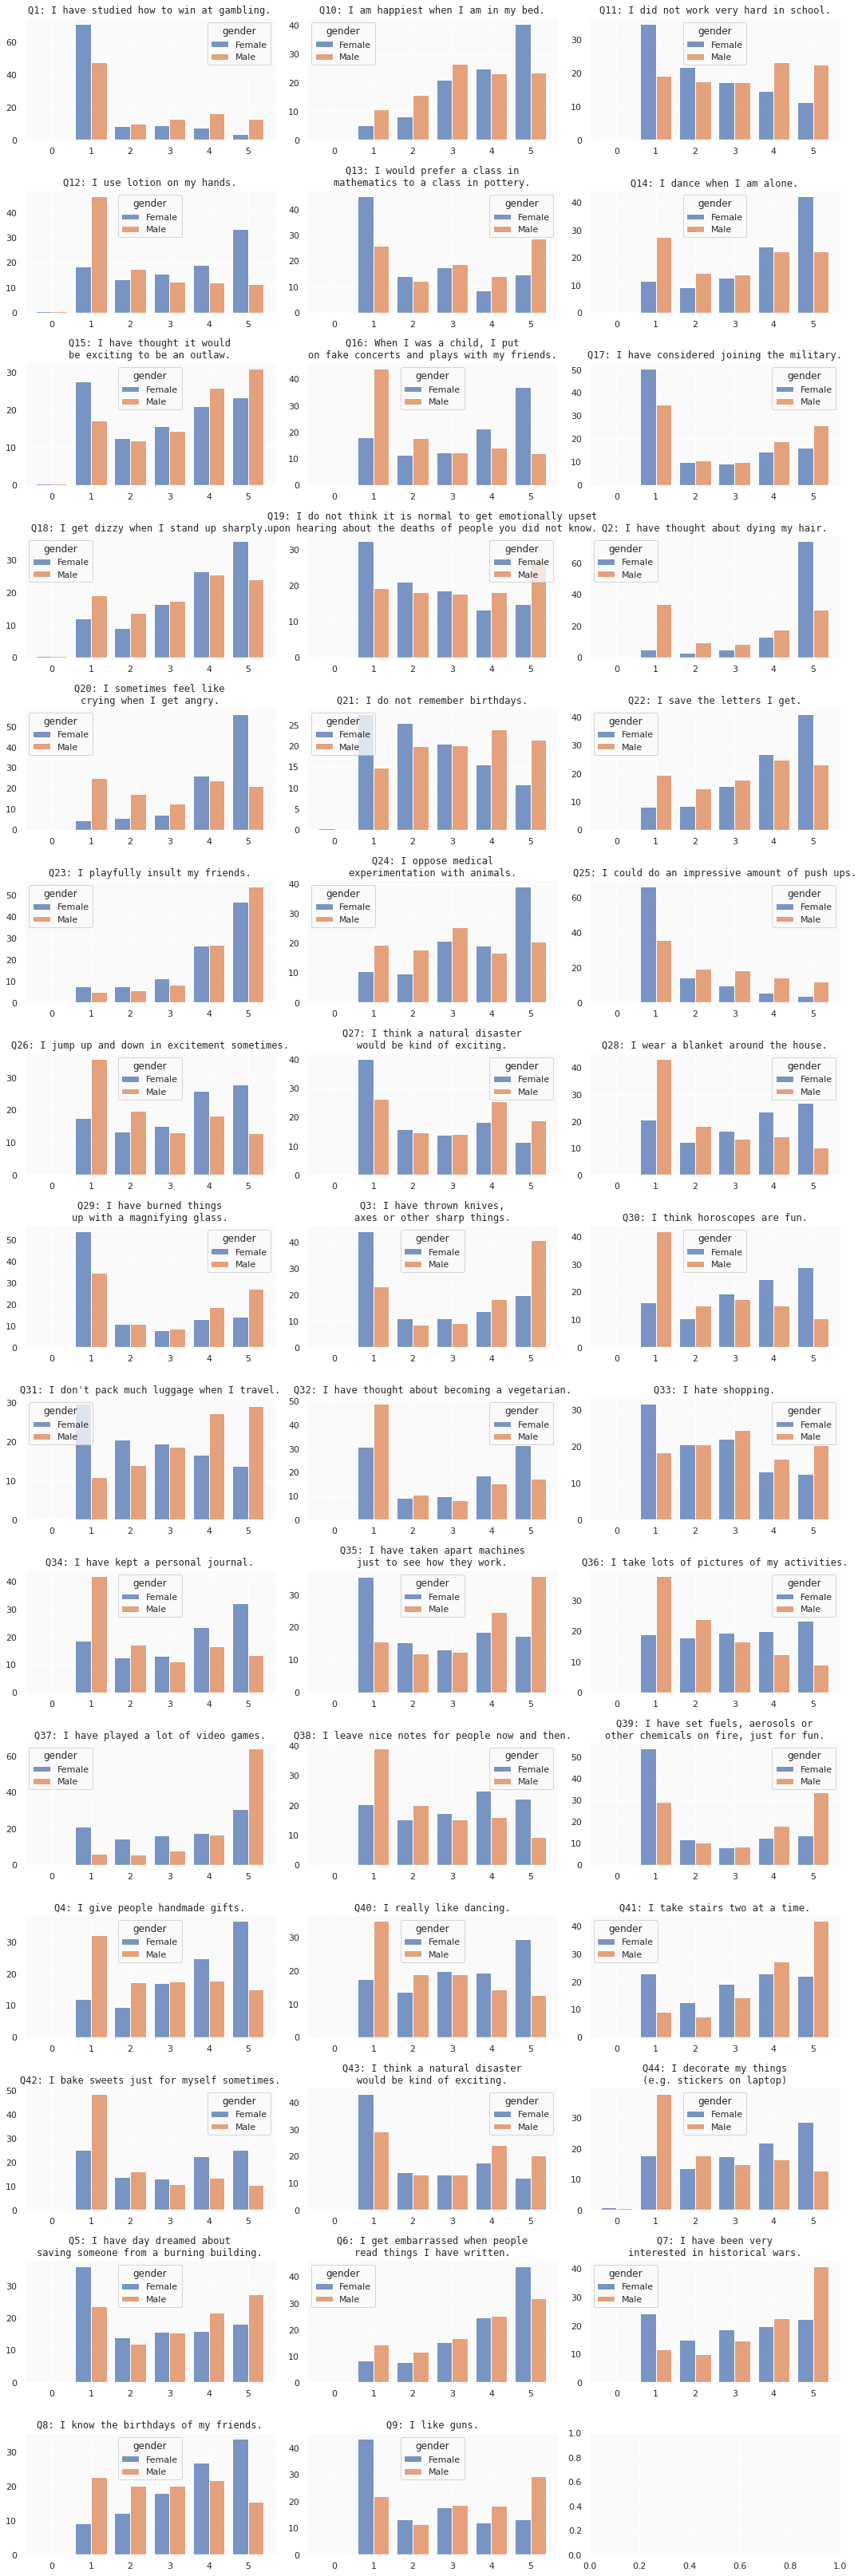

In [14]:
num_plots = len(questions_dict)
n_cols = 3
n_rows = int(np.ceil((num_plots / n_cols)))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,45))
fig.patch.set_facecolor('white')
for question, ax in zip(questions_dict, flatten(axs)):
    plot_question(question, ax, df[df.gender != 'Other'], hue='gender')
plt.tight_layout()

# Are distributions statistically different?

In [15]:
df.education = df.education.fillna('Unknown')
df.orientation = df.orientation.fillna('Unknown')
df.religion = df.religion.fillna('Unknown')
df.hand = df.hand.fillna('Right')

df = df.drop(['hand', 'country', 'IPC', 'source'], axis=1)

In [16]:
from sklearn.cluster import KMeans

In [17]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(df[QUESTION_COLS].values)

KMeans(n_clusters=2)

In [18]:
df['cluster'] = kmeans.labels_

In [19]:
df.groupby('cluster').gender.value_counts().groupby(level=0).apply(lambda x: np.round(x/x.sum()*100,2)).unstack()

gender   Female   Male  Other
cluster                      
0          70.1  19.90  10.00
1          20.0  74.28   5.72

In [20]:
df.groupby('cluster').race.value_counts().groupby(level=0).apply(lambda x: np.round(x/x.sum()*100,2)).unstack()

race     Asian  Black  Mixed race  Native American  Native Australian  Other  \
cluster                                                                        
0         7.70   6.16        9.73             0.92               0.13   6.16   
1         7.76   3.21       10.04             0.90               0.16   5.90   

race     White  
cluster         
0        69.21  
1        72.03

In [21]:
df.groupby('cluster').education.value_counts().groupby(level=0).apply(lambda x: np.round(x/x.sum()*100,2)).unstack()

education  < High School  Bachelor Degree  Graduate degree  High School  \
cluster                                                                   
0                  13.72            25.05             7.06        53.45   
1                  14.31            24.68             8.19        52.18   

education  Unknown  
cluster             
0             0.73  
1             0.63

In [22]:
df.groupby('cluster').religion.value_counts().groupby(level=0).apply(lambda x: np.round(x/x.sum()*100,2)).unstack()

religion  Atheist  Buddhist  Christian  Hindu  Jewish  Muslim  Other  Unknown
cluster                                                                      
0           45.81      1.67      29.26   0.76    1.57    2.01  15.81      3.1
1           53.68      1.41      26.65   0.88    1.28    2.27  11.13      2.7

In [23]:
df.groupby(['education', 'gender']).count().Q1.unstack()

gender           Female   Male  Other
education                            
< High School     21203  17417   5234
Bachelor Degree   39650  33173   5396
Graduate degree   11343  11068   1211
High School       82938  69503  13851
Unknown            1133    769    259

In [38]:
def plot_answers(data, title=''):
    num_plots = len(questions_dict)
    n_cols = 3
    n_rows = int(np.ceil((num_plots / n_cols)))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,45))
    fig.patch.set_facecolor('white')
    for question, ax in zip(questions_dict, flatten(axs)):
        plot_question(question, ax, data, 'cluster')
    plt.tight_layout()
    fig.suptitle(title)

# Modelling: Predicting gender

In [24]:
def encode_categorical_variables(data, var_name):
    dummies = pd.get_dummies(data[[var_name]])
    data_plus_dummies = pd.concat([data, dummies], axis=1).drop(var_name, axis=1)
    return data_plus_dummies

In [28]:
temp = df.copy()

for var in tqdm(['education', 'orientation', 'race', 'religion']):
    temp = encode_categorical_variables(temp, var)#.drop(var, axis=1)
    
temp[[col for col in temp.columns if not col.startswith('Q')]].head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.54it/s]


introelapse  testelapse engnat  age  gender age_bin  cluster  \
0          579         211    Yes   18  Female   16-18        0   
1           63         242    Yes   19    Male   18-22        1   
2           24         265     No   18  Female   16-18        0   
3            3         231    Yes   19  Female   18-22        1   
4           25         274    Yes   16    Male     <16        1   

   education_< High School  education_Bachelor Degree  \
0                        0                          0   
1                        0                          0   
2                        0                          0   
3                        0                          1   
4                        0                          0   

   education_Graduate degree  ...  race_Other  race_White  religion_Atheist  \
0                          0  ...           0           1                 1   
1                          0  ...           0           1                 1   
2                          0  ...           0           0                 1   
3                          0  ...           0           1                 0   
4                          0  ...           0           1                 0   

   religion_Buddhist  religion_Christian  religion_Hindu  religion_Jewish  \
0                  0                   0               0                0   
1                  0                   0               0                0   
2                  0                   0               0                0   
3                  0                   1               0                0   
4                  0                   1               0                0   

   religion_Muslim  religion_Other  religion_Unknown  
0                0               0                 0  
1                0               0                 0  
2                0               0                 0  
3                0               0                 0  
4                0               0                 0  

[5 rows x 33 columns]

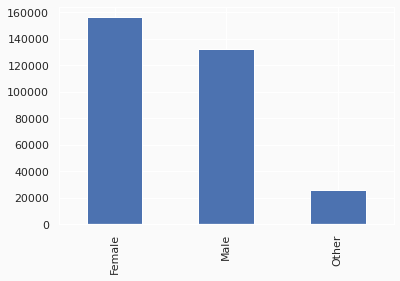

In [29]:
temp.gender.value_counts().plot.bar()
temp['is_female'] = (temp.gender == 'Female').astype(int)
temp = temp.drop(['introelapse', 'testelapse', 'engnat', 'cluster', 'gender'], axis=1)

In [30]:
temp.is_female.sum() / temp.shape[0]

0.4974311471026395

In [31]:
len(temp.columns) - 1

72

In [32]:
Y_LABEL= 'is_female'
temp1 = temp[[*QUESTION_COLS, 'is_female']]#.iloc[:100000]

y = temp1[Y_LABEL]
X = temp1.drop(Y_LABEL, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [39]:
lgbm = LGBMClassifier(max_depth=10, colsample_bytree=0.7)
rf = RandomForestClassifier(max_depth=10)

models = [lgbm, rf]

In [40]:
for model in tqdm(models):
    model.fit(X_train, y_train)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:30<00:00, 15.02s/it]


In [41]:
results = pd.DataFrame({'actuals': y_test})
metrics = dict()

for model in tqdm(models):
    preds = model.predict(X_test)
    results[f'preds_{model.__class__.__name__}'] = model.predict_proba(X_test)[:, 1]
    metrics[model.__class__.__name__] = dict()
    for metric in [precision_score, recall_score, roc_auc_score, accuracy_score]:
        metrics[model.__class__.__name__][metric.__name__] = metric(results.actuals, preds)
        
metrics = pd.DataFrame(metrics).T
metrics

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/it]


precision_score  recall_score  roc_auc_score  \
LGBMClassifier                 0.776540      0.822679       0.794178   
RandomForestClassifier         0.760835      0.824566       0.784005   

                        accuracy_score  
LGBMClassifier                0.794032  
RandomForestClassifier        0.783798

<AxesSubplot:>

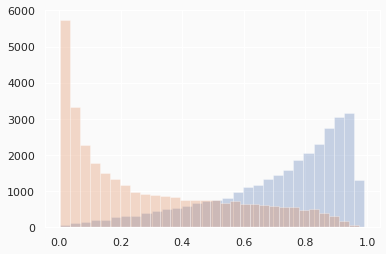

In [89]:
results.query('actuals == 1').preds_LGBMClassifier.hist(bins=30, alpha=0.3)
results.query('actuals == 0').preds_LGBMClassifier.hist(bins=30, alpha=0.3)

[]

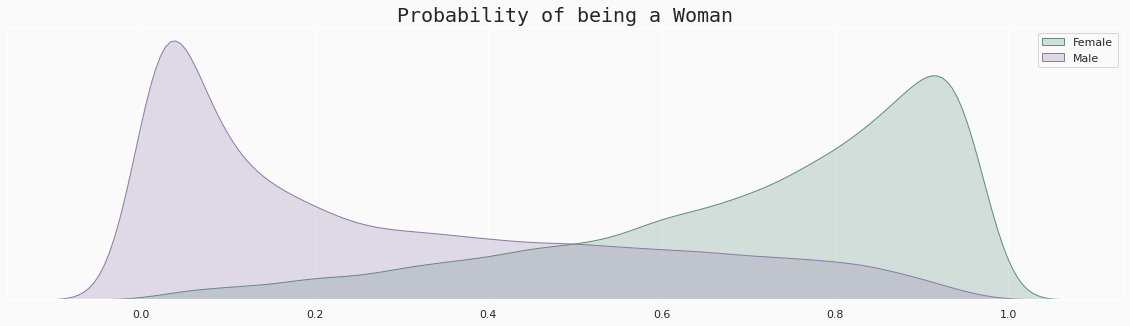

In [161]:
data_women = results.query('actuals == 1').preds_LGBMClassifier
data_men = results.query('actuals == 0').preds_LGBMClassifier

fig, ax = plt.subplots(1, 1, figsize=(20,5))
sns.kdeplot(data_women, fill=True, label='Female', ax=ax, color='#5b8e7d')
sns.kdeplot(data_men, fill=True, label='Male', ax=ax, color='#8c7aa9')

plt.legend()
plt.title('Probability of being a Woman',
          fontfamily='monospace',
          fontsize=20)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticks([])

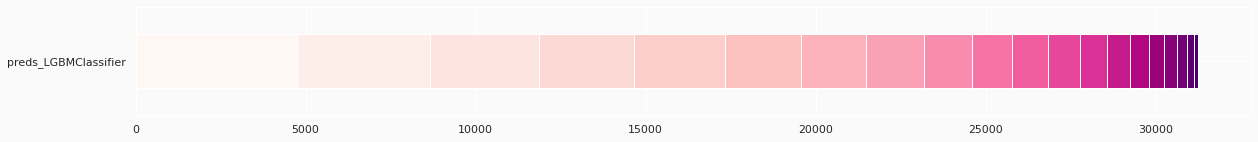

In [141]:
data = pd.DataFrame(pd.cut(results.query('actuals == 1').preds_LGBMClassifier, 20).value_counts()).T

fig, ax = plt.subplots(1, 1, figsize=(20,2))
data.plot.barh(stacked=True, cmap = 'RdPu', ax=ax)
ax.get_legend().remove()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.880
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.868


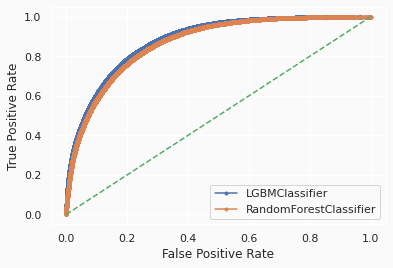

In [42]:
ns_probs = [0 for _ in range(len(y_test))]

# calculate scores
for model in models:
    probs = model.predict_proba(X_test)[:, 1]
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, probs)
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model.__class__.__name__)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.show()

In [43]:
threshold = 0.5
results['rf'] = (results.preds_RandomForestClassifier >= threshold).astype(int)
results['lg'] = (results.preds_LogisticRegression >= threshold).astype(int)

wront_preds = results.query('actuals != rf')
wront_preds.merge(df, left_index=True, right_index=True)

AttributeError: 'DataFrame' object has no attribute 'preds_LogisticRegression'

In [171]:
results = results.join(X_test)

In [174]:
results.query('(actuals == 1) & (preds_LGBMClassifier < 0.5)')
results['low_prob_female'] = results.preds_LGBMClassifier < 0.5

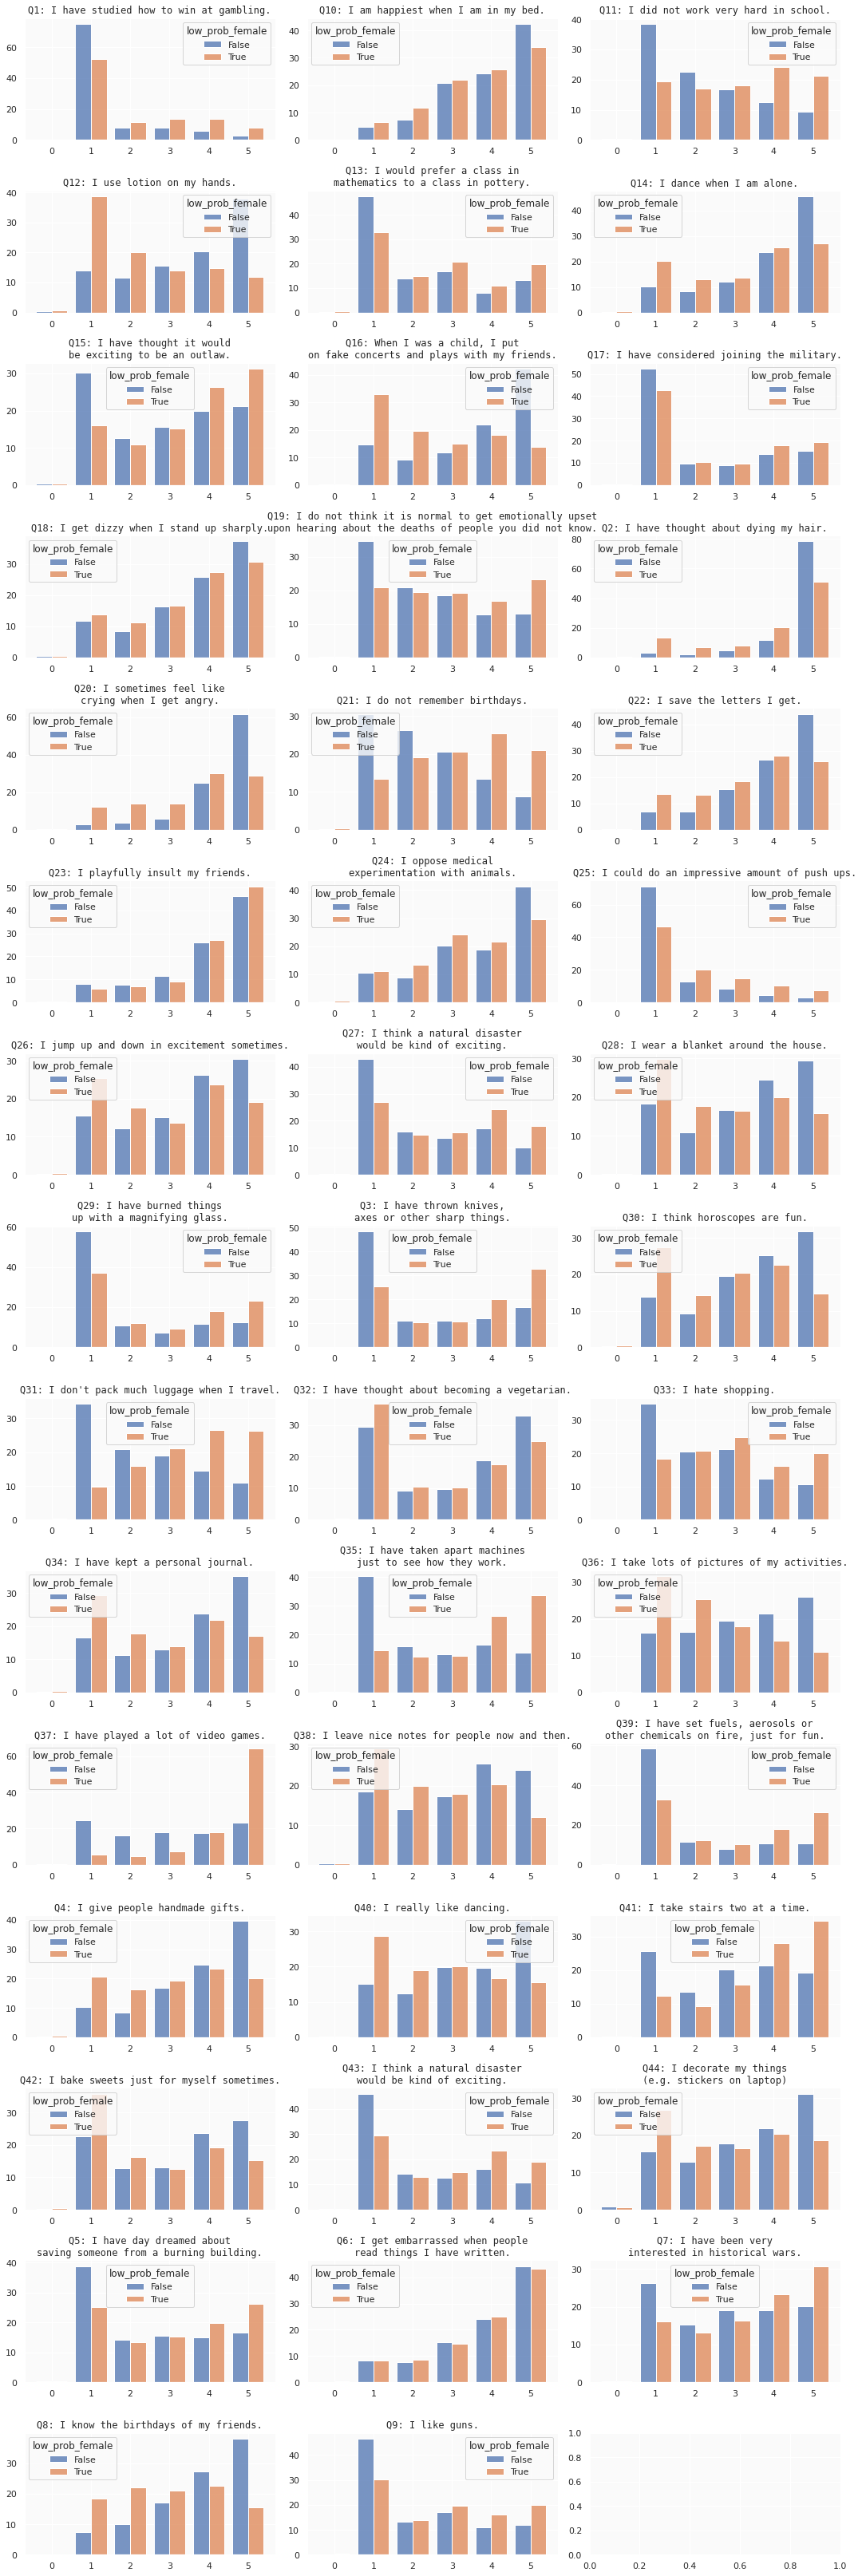

In [176]:
num_plots = len(questions_dict)
n_cols = 3
n_rows = int(np.ceil((num_plots / n_cols)))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,45))
fig.patch.set_facecolor('white')
for question, ax in zip(questions_dict, flatten(axs)):
    plot_question(question, ax, results.query('(actuals == 1)'), hue='low_prob_female')
plt.tight_layout()

## Feature Importances

In [81]:
shap.initjs()
import lightgbm as lgbm

In [83]:
d_train = lgbm.Dataset(X_train, label=y_train)
d_test = lgbm.Dataset(X_test, label=y_test)

params = {
    "max_depth": 10,
}

model = lgbm.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

/home/jumbo/.cache/pypoetry/virtualenvs/mars-venus-GBjGtfb3-py3.9/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/jumbo/.cache/pypoetry/virtualenvs/mars-venus-GBjGtfb3-py3.9/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 251318, number of used features: 44
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.497430
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[668]	valid_0's l2: 0.140165


In [84]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

KeyError: 'objective'

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X.iloc[0,:])

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_display.iloc[:1000,:])

<AxesSubplot:>

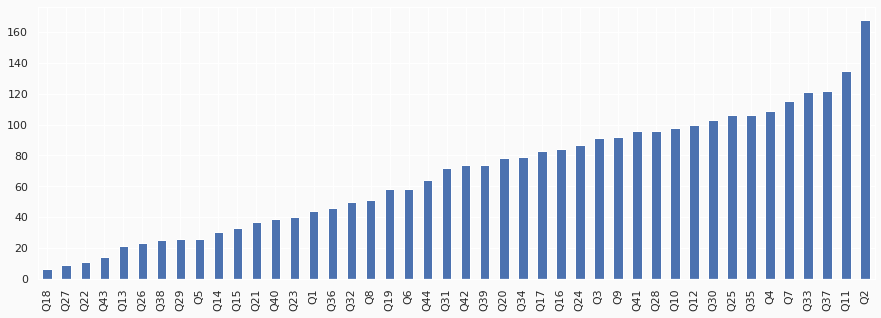

In [44]:
importances = pd.Series(dict(zip(list(X.columns), lgbm.feature_importances_))).sort_values()
importances.plot.bar(figsize=(15,5))

In [45]:
top_questions = importances.tail(10).index[::-1]
for q in top_questions:
    print(f'{q}: {questions_dict[q]}')

Q2: I have thought about dying my hair.
Q11: I did not work very hard in school.
Q37: I have played a lot of video games.
Q33: I hate shopping.
Q7: I have been very interested in historical wars.
Q4: I give people handmade gifts.
Q35: I have taken apart machines just to see how they work.
Q25: I could do an impressive amount of push ups.
Q30: I think horoscopes are fun.
Q12: I use lotion on my hands.
